Datasets used: 
- `Law School Success` :<br>
The dataset was originally collected for a study called 'LSAC National Longitudinal Bar Passage Study'. It includes background information and if (and how) candidates passed the bar exam to become lawyers/legal practicioners in the USA<br>

    Important Variables:
    
    gender: Gender of the student.<br>
    lsat: LSAT score received by the student.<br>
    pass_bar: Ground truth label indicating whether or not the student eventually passed the bar.<br>
    race: Race of the student.<br>
    gpa: A student's undergraduate GPA.<br>

Reference Links: https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage?resource=download

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
sensitive_attribute = "gender"

## Load Dataset

In [3]:
DATAFILE= "bar_pass_prediction.csv"

#learning_class_weights = {0: 50, 1: 5}

X = pd.read_csv(DATAFILE)
#Drop unnecessary features
X = X.drop(columns=['sex','dnn_bar_pass_prediction','ID','bar_passed','race',
                    'race2','decile1b','decile3','decile1','asian','black','hisp','other','index6040','bar1','bar2','DOB_yr','male','bar','indxgrp','indxgrp2','grad'
                    ,'bar1_yr','bar2_yr','parttime','age','cluster','zgpa','fulltime','fam_inc','Dropout','tier','gpa','pass_bar'])
num_features = X._get_numeric_data().columns.to_list()

df = X.copy()
cate_features = df.select_dtypes(include=['object']).columns.to_list()
df = df.dropna()
df = df.reset_index(drop=True)

df.head()

,lsat,ugpa,zfygpa,gender,race1
0,44.0,3.5,1.33,female,white
1,29.0,3.5,-0.11,female,white
2,36.0,3.5,-0.64,male,white
3,39.0,3.5,0.34,male,white
4,48.0,3.5,1.02,male,white


In [4]:
df.zfygpa = np.where(df.zfygpa >= df.zfygpa.median(),1,0)

In [5]:
df.head()

,lsat,ugpa,zfygpa,gender,race1
0,44.0,3.5,1,female,white
1,29.0,3.5,0,female,white
2,36.0,3.5,0,male,white
3,39.0,3.5,1,male,white
4,48.0,3.5,1,male,white


## Model training and test

In [6]:
X = df.drop('zfygpa', axis=1)
y = df['zfygpa']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [7]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='labels')
model.predict(X_test.iloc[:100, :])

CPU times: total: 46.9 ms
Wall time: 70.7 ms


array([1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1.])

In [8]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.63      0.51      0.57      3206
           1       0.59      0.70      0.64      3216

    accuracy                           0.61      6422
   macro avg       0.61      0.61      0.60      6422
weighted avg       0.61      0.61      0.60      6422



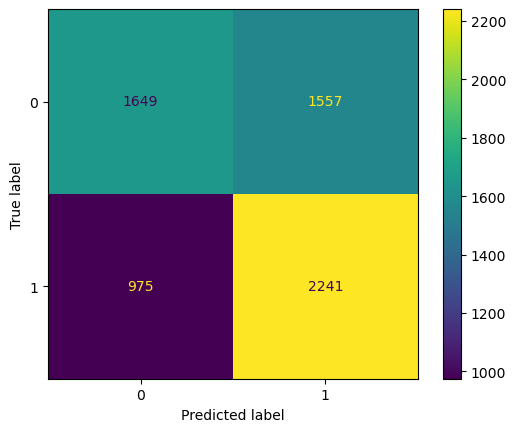

In [9]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [10]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
     X_test,
     model=model,
     sensitive_attribute='gender',
     missing_subgroup_val="Unknown"
 )

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 42.74it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1401.37it/s]

Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.



100%|███████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 14545.65it/s]

Computing correctenesses for all valid if-thens.



100%|█████████████████████████████████████████████████████████████████████████████| 1069/1069 [00:06<00:00, 172.92it/s]

Number of if-thens: 1069


In [12]:
#### Uncomment if you wish to load rules object from disk

import dill

with open("rulesLawSchool.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [13]:
#### Uncomment if you wish to save rules object on disk

import dill

with open("rulesLawSchool.data", "wb") as outf:
     dill.dump(rules_by_if, outf)

In [11]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["male"][1][0][1]-e[1]["female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If ugpa = 2.3:
	Subgroup 'female', 1.36% covered
		Make ugpa = 3.4 with correctness 11.11%.
		Make ugpa = 3.5 with correctness 11.11%.
		Make ugpa = 3.6 with correctness 16.67%.
		Make ugpa = 3.2 with correctness 11.11%.
		Make ugpa = 3.7 with correctness 16.67%.
		Make ugpa = 3.3 with correctness 11.11%.
		Make ugpa = 3.1 with correctness 11.11%.
		Make ugpa = 3.8 with correctness 16.67%.
		Make ugpa = 3.0 with correctness 11.11%.
		Make ugpa = 3.9 with correctness 16.67%.
		Make ugpa = 2.9 with correctness 11.11%.
		Make ugpa = 2.8 with correctness 11.11%.
		Make ugpa = 2.7 with correctness 11.11%.
		Make ugpa = 2.6 with correctness 0.00%.
	Subgroup 'male', 2.69% covered
		Make ugpa = 3.4 with correctness 51.43%.
		Make ugpa = 3.5 with correctness 57.14%.
		Make ugpa = 3.6 with correctness 57.14%.
		Make ugpa = 3.2 with correctness 48.57%.
		Make ugpa = 3.7 with correctness 57.14%.
		Make ugpa = 3.3 with correctness 48.57%.
		Make ugpa = 3.1 with correctness 45.71%.
		Make ugpa = 3.8

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [12]:
feature_weights = {"gender": 1, "race1": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [13]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If ugpa = 2.3:
	Subgroup 'female', 1.36% covered out of 9331
		Make ugpa = 3.4 with correctness 11.11%.
		Make ugpa = 3.5 with correctness 11.11%.
		Make ugpa = 3.6 with correctness 16.67%.
		Make ugpa = 3.2 with correctness 11.11%.
		Make ugpa = 3.7 with correctness 16.67%.
		Make ugpa = 3.3 with correctness 11.11%.
		Make ugpa = 3.1 with correctness 11.11%.
		Make ugpa = 3.8 with correctness 16.67%.
		Make ugpa = 3.0 with correctness 11.11%.
		Make ugpa = 3.9 with correctness 16.67%.
		Make ugpa = 2.9 with correctness 11.11%.
		Make ugpa = 2.8 with correctness 11.11%.
		Make ugpa = 2.7 with correctness 11.11%.
		Make ugpa = 2.6 with correctness 0.00%.
		Aggregate cost of the above recourses = -0.12
	Subgroup 'male', 2.69% covered out of 12075
		Make ugpa = 3.4 with correctness 51.43%.
		Make ugpa = 3.5 with correctness 57.14%.
		Make ugpa = 3.6 with correctness 57.14%.
		Make ugpa = 3.2 with correctness 48.57%.
		Make ugpa = 3.7 with correctness 57.14%.
		Make ugpa = 3.3 with correct

## Minimum cost above threshold

In [14]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
    secondary_sorting=True
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If race1 = asian:
	Subgroup 'female', 9.67% covered out of 9331
		Make race1 = white with correctness 57.03%.
		Aggregate cost of the above recourses = 1.00
	Subgroup 'male', 9.00% covered out of 12075
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Bias against male. Unfairness measure = inf.
If ugpa = 3.0:
	Subgroup 'female', 9.29% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 8.92% covered out of 12075
		Make ugpa = 3.8 with correctness 51.72%.
		Make ugpa = 3.9 with correctness 55.17%.
		Aggregate cost of the above recourses = 1.00
	Bias against female. Unfairness measure = inf.
If ugpa = 3.2:
	Subgroup 'female', 8.99% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 8.31% covered out of 12075
		Make ugpa = 3.8 with correctness 57.41%.
		Make ugpa = 3.9 with correctness 57.41%.
		Aggregate cost of the above rec

## Mean cost above threshold

In [15]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If race1 = asian:
	Subgroup 'female', 9.67% covered out of 9331
		Make race1 = white with correctness 57.03%.
		Aggregate cost of the above recourses = 1.00
	Subgroup 'male', 9.00% covered out of 12075
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Bias against male. Unfairness measure = inf.
If ugpa = 3.0:
	Subgroup 'female', 9.29% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 8.92% covered out of 12075
		Make ugpa = 3.8 with correctness 51.72%.
		Make ugpa = 3.9 with correctness 55.17%.
		Aggregate cost of the above recourses = 1.00
	Bias against female. Unfairness measure = inf.
If ugpa = 3.2:
	Subgroup 'female', 8.99% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 8.31% covered out of 12075
		Make ugpa = 3.8 with correctness 57.41%.
		Make ugpa = 3.9 with correctness 57.41%.
		Aggregate cost of the above rec

## Number above threshold

In [16]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If lsat = 28.0:
	Subgroup 'female', 4.38% covered out of 9331
		Make lsat = 48.0 with correctness 51.72%.
		Aggregate cost of the above recourses = -1.00
	Subgroup 'male', 3.85% covered out of 12075
		Make lsat = 40.0 with correctness 62.00%.
		Make lsat = 39.0 with correctness 54.00%.
		Make lsat = 37.0 with correctness 52.00%.
		Make lsat = 42.0 with correctness 64.00%.
		Make lsat = 38.0 with correctness 52.00%.
		Make lsat = 41.0 with correctness 62.00%.
		Make lsat = 36.0 with correctness 50.00%.
		Make lsat = 44.0 with correctness 64.00%.
		Make lsat = 43.0 with correctness 64.00%.
		Make lsat = 45.0 with correctness 66.00%.
		Make lsat = 46.0 with correctness 68.00%.
		Make lsat = 47.0 with correctness 68.00%.
		Make lsat = 48.0 with correctness 70.00%.
		Aggregate cost of the above recourses = -13.00
	Bias against female. Unfairness measure = 12.
If lsat = 29.0:
	Subgroup 'female', 4.15% covered out of 9331
		Make lsat = 45.0 with correctness 50.91%.
		Make lsat = 46.0 with cor

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [20]:
import dill

with open("stateLawSchool.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

Trying to unpickle estimator LogisticRegression from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator OneHotEncoder from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LabelEncoder from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


If ugpa = 2.3:
	Subgroup 'female', 1.36% covered out of 9331
		Make ugpa = 3.4 with correctness 11.11%.
		Make ugpa = 3.5 with correctness 11.11%.
		Make ugpa = 3.6 with correctness 16.67%.
		Make ugpa = 3.2 with correctness 11.11%.
		Make ugpa = 3.7 with correctness 16.67%.
		Make ugpa = 3.3 with correctness 11.11%.
		Make ugpa = 3.1 with correctness 11.11%.
		Make ugpa = 3.8 with correctness 16.67%.
		Make ugpa = 3.0 with correctness 11.11%.
		Make ugpa = 3.9 with correctness 16.67%.
		Make ugpa = 2.9 with correctness 11.11%.
		Make ugpa = 2.8 with correctness 11.11%.
		Make ugpa = 2.7 with correctness 11.11%.
		Make ugpa = 2.6 with correctness 0.00%.
	Subgroup 'male', 2.69% covered out of 12075
		Make ugpa = 3.4 with correctness 51.43%.
		Make ugpa = 3.5 with correctness 57.14%.
		Make ugpa = 3.6 with correctness 57.14%.
		Make ugpa = 3.2 with correctness 48.57%.
		Make ugpa = 3.7 with correctness 57.14%.
		Make ugpa = 3.3 with correctness 48.57%.
		Make ugpa = 3.1 with correctness 

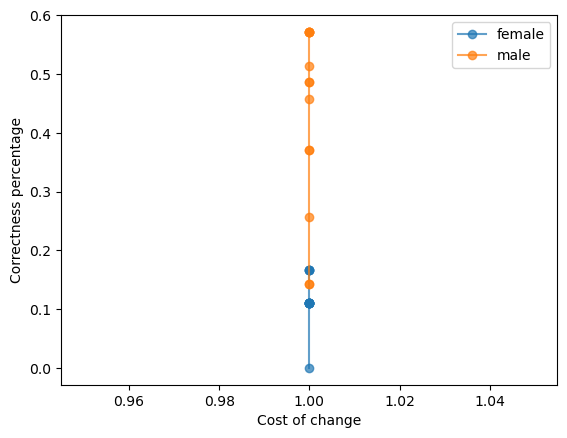

If ugpa = 2.5:
	Subgroup 'female', 3.70% covered out of 9331
		Make ugpa = 3.4 with correctness 14.29%.
		Make ugpa = 3.5 with correctness 20.41%.
		Make ugpa = 3.6 with correctness 20.41%.
		Make ugpa = 3.2 with correctness 14.29%.
		Make ugpa = 3.7 with correctness 20.41%.
		Make ugpa = 3.3 with correctness 14.29%.
		Make ugpa = 3.1 with correctness 14.29%.
		Make ugpa = 3.8 with correctness 22.45%.
		Make ugpa = 3.0 with correctness 14.29%.
		Make ugpa = 3.9 with correctness 22.45%.
		Make ugpa = 2.9 with correctness 10.20%.
		Make ugpa = 2.8 with correctness 8.16%.
		Make ugpa = 2.7 with correctness 8.16%.
		Make ugpa = 2.6 with correctness 0.00%.
	Subgroup 'male', 5.08% covered out of 12075
		Make ugpa = 3.4 with correctness 46.97%.
		Make ugpa = 3.5 with correctness 50.00%.
		Make ugpa = 3.6 with correctness 51.52%.
		Make ugpa = 3.2 with correctness 40.91%.
		Make ugpa = 3.7 with correctness 51.52%.
		Make ugpa = 3.3 with correctness 40.91%.
		Make ugpa = 3.1 with correctness 36

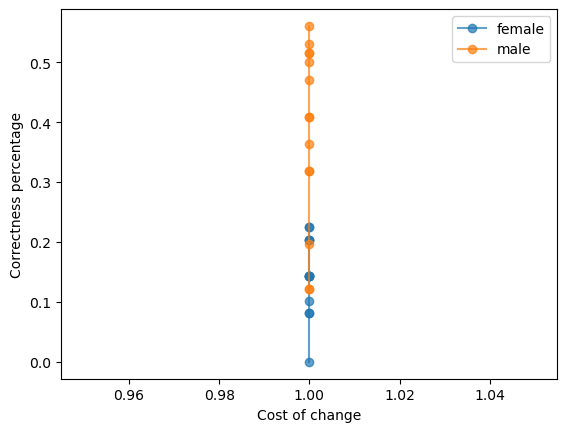

If ugpa = 2.6:
	Subgroup 'female', 4.23% covered out of 9331
		Make ugpa = 3.4 with correctness 23.21%.
		Make ugpa = 3.5 with correctness 23.21%.
		Make ugpa = 3.6 with correctness 23.21%.
		Make ugpa = 3.2 with correctness 17.86%.
		Make ugpa = 3.7 with correctness 23.21%.
		Make ugpa = 3.3 with correctness 21.43%.
		Make ugpa = 3.1 with correctness 8.93%.
		Make ugpa = 3.8 with correctness 26.79%.
		Make ugpa = 3.0 with correctness 8.93%.
		Make ugpa = 3.9 with correctness 26.79%.
		Make ugpa = 2.9 with correctness 1.79%.
		Make ugpa = 2.8 with correctness 1.79%.
		Make ugpa = 2.7 with correctness 1.79%.
	Subgroup 'male', 6.31% covered out of 12075
		Make ugpa = 3.4 with correctness 48.78%.
		Make ugpa = 3.5 with correctness 54.88%.
		Make ugpa = 3.6 with correctness 56.10%.
		Make ugpa = 3.2 with correctness 39.02%.
		Make ugpa = 3.7 with correctness 56.10%.
		Make ugpa = 3.3 with correctness 41.46%.
		Make ugpa = 3.1 with correctness 30.49%.
		Make ugpa = 3.8 with correctness 60.9

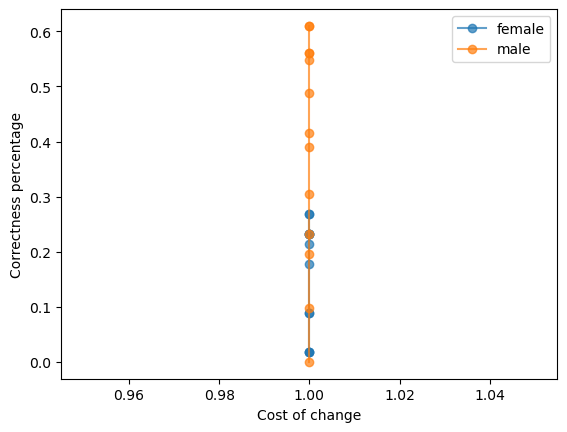

If race1 = white, ugpa = 2.6:
	Subgroup 'female', 1.89% covered out of 9331
		Make ugpa = 3.4 with correctness 52.00%.
		Make ugpa = 3.5 with correctness 52.00%.
		Make ugpa = 3.6 with correctness 52.00%.
		Make ugpa = 3.2 with correctness 40.00%.
		Make ugpa = 3.7 with correctness 52.00%.
		Make ugpa = 3.3 with correctness 48.00%.
		Make ugpa = 3.1 with correctness 20.00%.
		Make ugpa = 3.8 with correctness 60.00%.
		Make ugpa = 3.0 with correctness 20.00%.
		Make ugpa = 3.9 with correctness 60.00%.
		Make ugpa = 2.9 with correctness 4.00%.
		Make ugpa = 2.8 with correctness 4.00%.
		Make ugpa = 2.7 with correctness 4.00%.
	Subgroup 'male', 4.23% covered out of 12075
		Make ugpa = 3.4 with correctness 70.91%.
		Make ugpa = 3.5 with correctness 80.00%.
		Make ugpa = 3.6 with correctness 80.00%.
		Make ugpa = 3.2 with correctness 56.36%.
		Make ugpa = 3.7 with correctness 80.00%.
		Make ugpa = 3.3 with correctness 60.00%.
		Make ugpa = 3.1 with correctness 43.64%.
		Make ugpa = 3.8 with

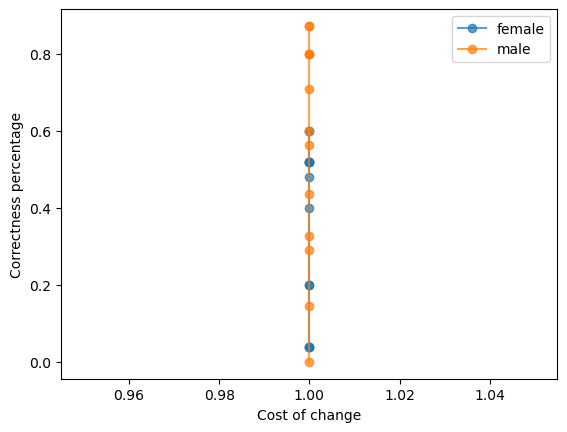

If lsat = 29.0:
	Subgroup 'female', 4.15% covered out of 9331
		Make lsat = 40.0 with correctness 45.45%.
		Make lsat = 39.0 with correctness 43.64%.
		Make lsat = 37.0 with correctness 34.55%.
		Make lsat = 42.0 with correctness 45.45%.
		Make lsat = 38.0 with correctness 36.36%.
		Make lsat = 41.0 with correctness 45.45%.
		Make lsat = 36.0 with correctness 30.91%.
		Make lsat = 35.0 with correctness 30.91%.
		Make lsat = 44.0 with correctness 49.09%.
		Make lsat = 43.0 with correctness 47.27%.
		Make lsat = 45.0 with correctness 50.91%.
		Make lsat = 34.0 with correctness 20.00%.
		Make lsat = 46.0 with correctness 52.73%.
		Make lsat = 47.0 with correctness 56.36%.
		Make lsat = 33.0 with correctness 16.36%.
		Make lsat = 48.0 with correctness 60.00%.
	Subgroup 'male', 4.15% covered out of 12075
		Make lsat = 40.0 with correctness 62.96%.
		Make lsat = 39.0 with correctness 61.11%.
		Make lsat = 37.0 with correctness 55.56%.
		Make lsat = 42.0 with correctness 64.81%.
		Make lsat =

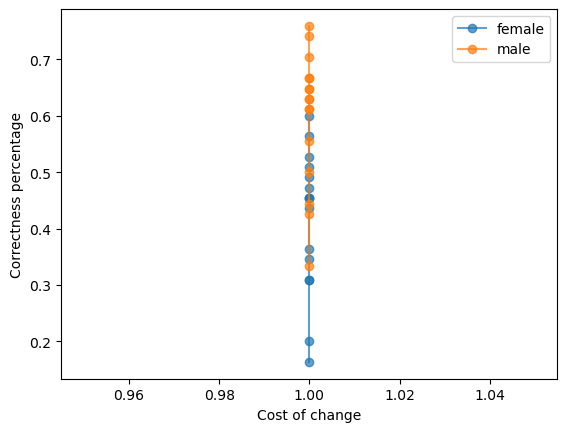

If lsat = 29.5:
	Subgroup 'female', 1.28% covered out of 9331
		Make lsat = 40.0 with correctness 64.71%.
		Make lsat = 39.0 with correctness 64.71%.
		Make lsat = 37.0 with correctness 58.82%.
		Make lsat = 42.0 with correctness 64.71%.
		Make lsat = 38.0 with correctness 64.71%.
		Make lsat = 41.0 with correctness 64.71%.
		Make lsat = 36.0 with correctness 41.18%.
		Make lsat = 35.0 with correctness 35.29%.
		Make lsat = 44.0 with correctness 64.71%.
		Make lsat = 43.0 with correctness 64.71%.
		Make lsat = 45.0 with correctness 64.71%.
		Make lsat = 34.0 with correctness 23.53%.
		Make lsat = 46.0 with correctness 64.71%.
		Make lsat = 47.0 with correctness 64.71%.
		Make lsat = 33.0 with correctness 17.65%.
		Make lsat = 48.0 with correctness 70.59%.
	Subgroup 'male', 1.54% covered out of 12075
		Make lsat = 40.0 with correctness 80.00%.
		Make lsat = 39.0 with correctness 80.00%.
		Make lsat = 37.0 with correctness 70.00%.
		Make lsat = 42.0 with correctness 80.00%.
		Make lsat =

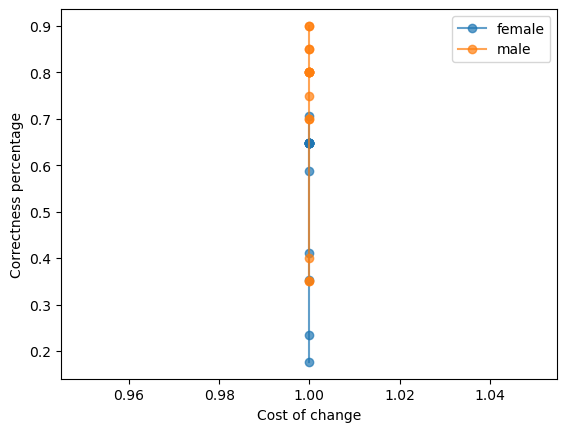

If lsat = 27.0:
	Subgroup 'female', 2.57% covered out of 9331
		Make lsat = 40.0 with correctness 41.18%.
		Make lsat = 39.0 with correctness 41.18%.
		Make lsat = 37.0 with correctness 38.24%.
		Make lsat = 42.0 with correctness 41.18%.
		Make lsat = 38.0 with correctness 38.24%.
		Make lsat = 41.0 with correctness 41.18%.
		Make lsat = 36.0 with correctness 29.41%.
		Make lsat = 35.0 with correctness 23.53%.
		Make lsat = 44.0 with correctness 41.18%.
		Make lsat = 43.0 with correctness 41.18%.
		Make lsat = 45.0 with correctness 41.18%.
		Make lsat = 34.0 with correctness 17.65%.
		Make lsat = 46.0 with correctness 41.18%.
		Make lsat = 47.0 with correctness 47.06%.
		Make lsat = 33.0 with correctness 14.71%.
		Make lsat = 48.0 with correctness 50.00%.
	Subgroup 'male', 2.54% covered out of 12075
		Make lsat = 40.0 with correctness 60.61%.
		Make lsat = 39.0 with correctness 51.52%.
		Make lsat = 37.0 with correctness 33.33%.
		Make lsat = 42.0 with correctness 66.67%.
		Make lsat =

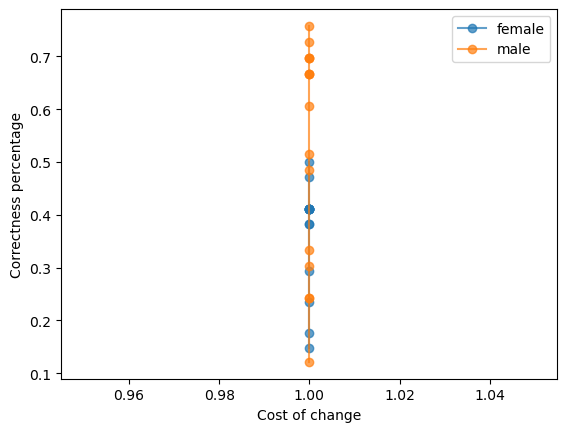

If lsat = 35.0:
	Subgroup 'female', 7.85% covered out of 9331
		Make lsat = 40.0 with correctness 66.35%.
		Make lsat = 39.0 with correctness 64.42%.
		Make lsat = 37.0 with correctness 37.50%.
		Make lsat = 42.0 with correctness 67.31%.
		Make lsat = 38.0 with correctness 48.08%.
		Make lsat = 41.0 with correctness 67.31%.
		Make lsat = 36.0 with correctness 14.42%.
		Make lsat = 44.0 with correctness 67.31%.
		Make lsat = 43.0 with correctness 67.31%.
		Make lsat = 45.0 with correctness 69.23%.
		Make lsat = 34.0 with correctness 0.00%.
		Make lsat = 46.0 with correctness 69.23%.
		Make lsat = 47.0 with correctness 72.12%.
		Make lsat = 33.0 with correctness 0.00%.
		Make lsat = 48.0 with correctness 75.00%.
	Subgroup 'male', 7.69% covered out of 12075
		Make lsat = 40.0 with correctness 84.00%.
		Make lsat = 39.0 with correctness 72.00%.
		Make lsat = 37.0 with correctness 53.00%.
		Make lsat = 42.0 with correctness 86.00%.
		Make lsat = 38.0 with correctness 69.00%.
		Make lsat = 4

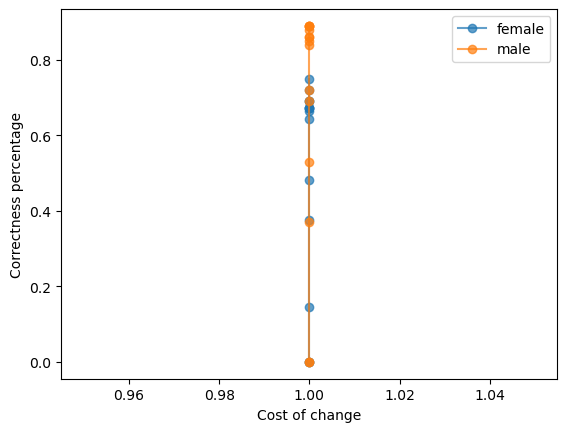

If race1 = other:
	Subgroup 'female', 3.40% covered out of 9331
		Make race1 = white with correctness 33.33%.
	Subgroup 'male', 4.15% covered out of 12075
		Make race1 = white with correctness 48.15%.
	Bias against female. Unfairness measure = 0.15.
	Cumulative correctness plot for the above recourses:


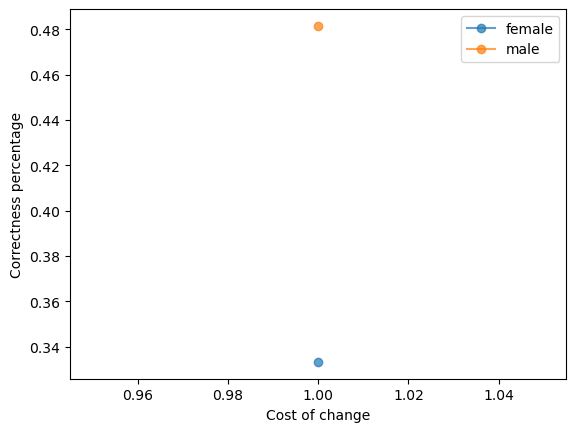

If lsat = 28.0:
	Subgroup 'female', 4.38% covered out of 9331
		Make lsat = 40.0 with correctness 44.83%.
		Make lsat = 39.0 with correctness 43.10%.
		Make lsat = 37.0 with correctness 37.93%.
		Make lsat = 42.0 with correctness 46.55%.
		Make lsat = 38.0 with correctness 39.66%.
		Make lsat = 41.0 with correctness 46.55%.
		Make lsat = 36.0 with correctness 36.21%.
		Make lsat = 35.0 with correctness 34.48%.
		Make lsat = 44.0 with correctness 48.28%.
		Make lsat = 43.0 with correctness 48.28%.
		Make lsat = 45.0 with correctness 48.28%.
		Make lsat = 34.0 with correctness 22.41%.
		Make lsat = 46.0 with correctness 48.28%.
		Make lsat = 47.0 with correctness 48.28%.
		Make lsat = 33.0 with correctness 17.24%.
		Make lsat = 48.0 with correctness 51.72%.
	Subgroup 'male', 3.85% covered out of 12075
		Make lsat = 40.0 with correctness 62.00%.
		Make lsat = 39.0 with correctness 54.00%.
		Make lsat = 37.0 with correctness 52.00%.
		Make lsat = 42.0 with correctness 64.00%.
		Make lsat =

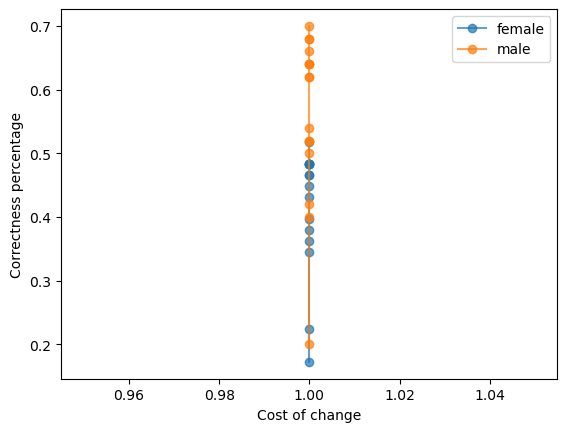

In [17]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="weighted-average",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute=sensitive_attribute)

pop_sizes = {sg: (df[sensitive_attribute] == sg).sum() for sg in df[sensitive_attribute].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [22]:
import dill

with open("stateLawSchool.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)